[View in Colaboratory](https://colab.research.google.com/github/gatchaman-20140215/reversi4/blob/master/mnist_nn_cnn_rnn.ipynb)

# MNIST

In [1]:
!apt-get install -y -qq libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80==4.0.0b4 
!pip install chainer==4.0.0b4

In [0]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.datasets import tuple_dataset
from chainer import training
from chainer.training import extensions

In [0]:
train, test = datasets.get_mnist(ndim=3)

この画像データのラベルは5です。


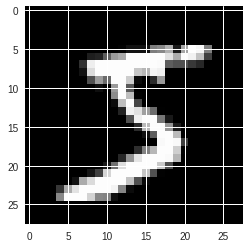

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(np.array(train[0][0][0], dtype=np.float32), cmap='gray')
print('この画像データのラベルは{:0d}です。'.format(train[0][1]))

## nn

In [0]:
class NN(Chain):
    def __init__(self, n_in, n_units, n_out):
        super(NN, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in, n_units)
            self.l2 = L.Linear(n_units, n_units)
            self.l3 = L.Linear(n_units, n_out)
    
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [0]:
gpu_device = 0
epoch = 30
batch_size = 512
frequency = -1
n_in = 784
n_units = 100
n_out = 10

In [7]:
model = L.Classifier(NN(n_in, n_units, n_out))
chainer.cuda.get_device_from_id(0)
model.to_gpu()

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_device)
trainer = training.Trainer(updater, (epoch, 'epoch'))

trainer.extend(extensions.Evaluator(test_iter, model,device=gpu_device))
trainer.extend(extensions.dump_graph('main/loss'))

frequency = epoch if frequency == -1 else max(1, frequency)
trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))
trainer.extend(extensions.LogReport())
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.609557    0.271625              0.83986        0.921639                  2.24247       
2           0.223956    0.190223              0.936165       0.942412                  3.91926       
3           0.169551    0.155889              0.95229        0.952826                  5.49803       
4           0.138876    0.130223              0.960069       0.960507                  7.12243       
5           0.114769    0.117665              0.966947       0.964746                  8.73528       
6           0.096983    0.113826              0.971994       0.965614                  10.3822       
7           0.0863535   0.0950723             0.97476        0.972306                  11.9649       
8           0.0738427   0.0943972             0.978816       0.971743                  13.6363       
9           0.0651506   0.0920507             0.98107        0.971375               

In [8]:
!ls result

accuracy.png  cg.dot  log  loss.png  snapshot_iter_3516  snapshot_iter_3600


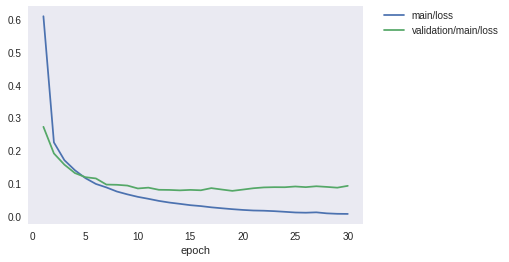

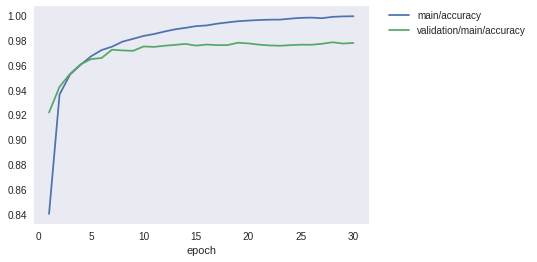

In [9]:
from IPython.display import Image, display_png

display_png(Image('result/loss.png'))
display_png(Image('result/accuracy.png'))

この画像データのラベルは7です。
[0.00000000372259179038 0.00000000087596779830 0.00000003106548618348
 0.00004456961323739961 0.00000000000002767143 0.00000000147911294324
 0.00000000000000000014 0.99994862079620361328 0.00000134408105623152
 0.00000531150408278336]


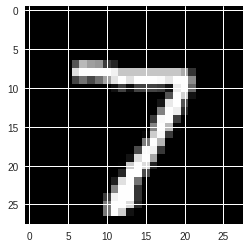

In [10]:
import cupy as cp

plt.imshow(np.array(test[0][0][0], dtype=np.float32), cmap='gray')
print('この画像データのラベルは{:0d}です。'.format(test[0][1]))
prediction = model.predictor(cp.array(test[0][0][0]).reshape(1, 784))
probability = chainer.cuda.to_cpu(F.softmax(prediction).data[0])
np.set_printoptions(precision=20, floatmode='fixed', suppress=True)
print(probability)

## CNN

In [0]:
class CNN(Chain):
    def __init__(self):
        super(CNN, self).__init__()
        with self.init_scope():
            self.cn1 = L.Convolution2D(1, 20, 5)
            self.cn2 = L.Convolution2D(20, 50, 5)
            self.fc1 = L.Linear(800, 500)
            self.fc2 = L.Linear(500, 10)
    
    def __call__(self, x):
        h1 = F.max_pooling_2d(F.relu(self.cn1(x)), 2)
        h2 = F.max_pooling_2d(F.relu(self.cn2(h1)), 2)
        h3 = F.dropout(F.relu(self.fc1(h2)))
        return self.fc2(h3)

In [0]:
gpu_device = 0
epoch = 30
batch_size = 512
frequency = -1

In [13]:
model = L.Classifier(CNN())
chainer.cuda.get_device_from_id(0)
model.to_gpu()

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_device)
trainer = training.Trainer(updater, (epoch, 'epoch'))

trainer.extend(extensions.Evaluator(test_iter, model,device=gpu_device))
trainer.extend(extensions.dump_graph('main/loss'))

frequency = epoch if frequency == -1 else max(1, frequency)
trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))
trainer.extend(extensions.LogReport())
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.354028    0.0805555             0.892197       0.974782                  2.43793       
2           0.0861291   0.0457051             0.97476        0.984651                  5.02699       
3           0.0603717   0.0358304             0.98152        0.98785                   7.64132       
4           0.0447528   0.029547              0.986278       0.990659                  10.286        
5           0.0393856   0.0300916             0.98748        0.990734                  12.9046       
6           0.0335107   0.0276662             0.98939        0.991355                  15.5664       
7           0.028251    0.0264475             0.991169       0.990682                  18.4082       
8           0.024206    0.0245272             0.992405       0.991234                  21.0302       
9           0.0213547   0.0207464             0.993339       0.992699               

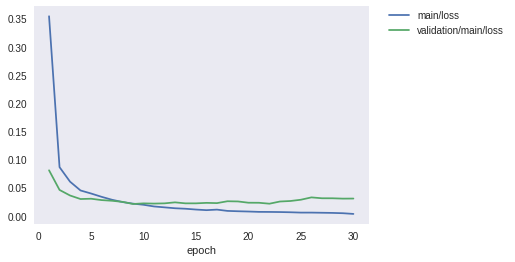

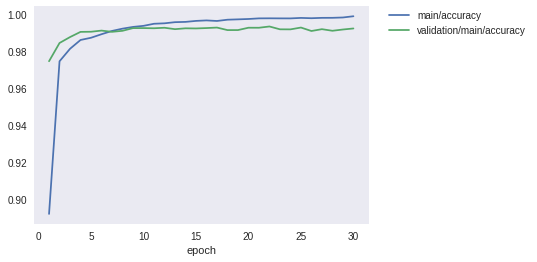

In [14]:
from IPython.display import Image, display_png

display_png(Image('result/loss.png'))
display_png(Image('result/accuracy.png'))

この画像データのラベルは7です。
[0.00000000000034654969 0.00000000001631320079 0.00000000017968711241
 0.00000000000952125098 0.00000000180500603353 0.00000000000172482167
 0.00000000000000372396 1.00000000000000000000 0.00000000000094331075
 0.00000000918344689183]


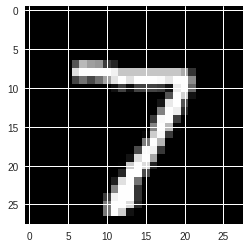

In [15]:
import cupy as cp

plt.imshow(np.array(test[0][0][0], dtype=np.float32), cmap='gray')
print('この画像データのラベルは{:0d}です。'.format(test[0][1]))
prediction = model.predictor(cp.array(test[0][0][0]).reshape(1, 1, 28, 28))
probability = chainer.cuda.to_cpu(F.softmax(prediction).data[0])
np.set_printoptions(precision=20, floatmode='fixed', suppress=True)
print(probability)

## RNN

In [0]:
gpu_device = 0
epoch = 30
batch_size = 500
frequency = -1

In [0]:
class RNN(Chain):
    def __init__(self):
        super(RNN, self).__init__()
        with self.init_scope():
            self.w1 = L.Linear(784, 100)
            self.h1 = L.Linear(100, 100)
            self.o = L.Linear(100, 10)
    
    def reset_state(self):
        self.last_z = chainer.Variable(cp.zeros((batch_size, 100), dtype=np.float32))
    
    def __call__(self, x):
        z = F.relu(self.w1(x) + self.h1(self.last_z))
        self.last_z = z
        y = F.relu(self.o(z))
        return y

In [19]:
rnn = RNN()
rnn.reset_state()
model = L.Classifier(rnn)
chainer.cuda.get_device_from_id(0)
model.to_gpu()

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(10.0))

train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_device)
trainer = training.Trainer(updater, (epoch, 'epoch'))

trainer.extend(extensions.Evaluator(test_iter, model,device=gpu_device))
trainer.extend(extensions.dump_graph('main/loss'))

frequency = epoch if frequency == -1 else max(1, frequency)
trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))
trainer.extend(extensions.LogReport())
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           1.12647     0.67986               0.676317       0.7929                    14.2889       
2           0.637657    0.561256              0.7971         0.8164                    28.7837       
3           0.554199    0.508853              0.816633       0.8303                    43.3512       
4           0.514805    0.482239              0.826266       0.8361                    57.8673       
5           0.482919    0.462028              0.834117       0.8405                    72.5115       
6           0.459542    0.436305              0.84055        0.8471                    87.0379       
7           0.439237    0.422526              0.845017       0.8518                    101.544       
8           0.422248    0.407439              0.850083       0.8552                    116.104       
9           0.408515    0.397422              0.853317       0.8583                 

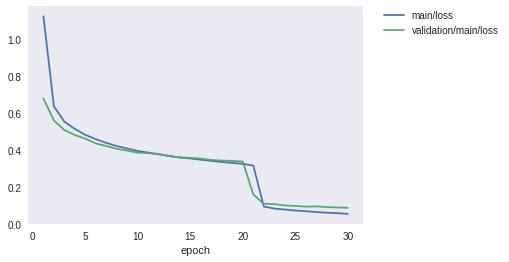

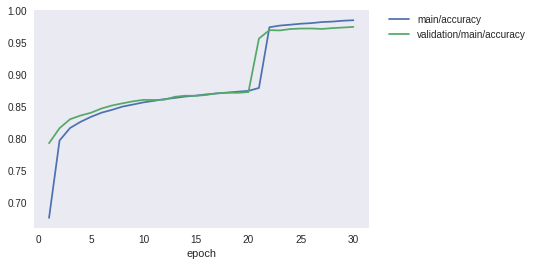

In [20]:
from IPython.display import Image, display_png

display_png(Image('result/loss.png'))
display_png(Image('result/accuracy.png'))